In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.f2py.crackfortran import verbose

np.set_printoptions(precision=3, suppress=True)

In [2]:
# Load the data
train = pd.read_csv('iitb-cs-725-1-2024/train.csv')
test = pd.read_csv('iitb-cs-725-1-2024/test.csv')
sample = pd.read_csv('iitb-cs-725-1-2024/sample.csv')

In [13]:
# Create datasets
def create_datasets(data):
    X = data.drop(['score', 'ID'], axis=1)
    y = data['score']
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    return X, y

# Shuffle the data
train = train.sample(frac=1).reset_index(drop=True)

n_train = int(0.9 * train.shape[0])
X_train, y_train = create_datasets(train[:n_train])
X_val, y_val = create_datasets(train[n_train:])

X_train.shape, X_val.shape

((31489, 64), (3499, 64))

In [125]:
import random

def predict(X, W):
    return X @ W

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# def rmse(y_true, y_pred):
#     return np.sqrt(mse(y_true, y_pred))

def compute_gradients(X, y, y_pred):
    dW = -2 * X.T @ (y - y_pred) / X.shape[0]
    return dW

def fit(X, y, W, Xval, yval, lr=0.01, epochs=100, print_every=100, batch_size=32):
    # Error list
    errors = []
    val_errors = []
    best_val_error = float('inf')
    best_W = None

    for i in range(epochs):
        # Mini-batch gradient descent
        idx = random.sample(range(X.shape[0]), batch_size)
        X_batch, y_batch = X[idx], y[idx]
        y_pred = predict(X_batch, W)

        if i % print_every == 0 or i == epochs - 1:
            train_loss = mse(y, predict(X, W))
            y_val_pred = predict(Xval, W)
            val_loss = mse(yval, y_val_pred)
            Y_val_round = y_val_pred.round()
            Y_val_rounded_loss = mse(yval, Y_val_round)
            print(f'Epoch {i}, Loss: {train_loss}, Val Loss: {val_loss}, Rounded Val Loss: {Y_val_rounded_loss}')
            errors.append(train_loss)
            val_errors.append(val_loss)
            if val_loss < best_val_error:
                best_val_error = val_loss
                best_W = W
            if train_loss < 0.8 and val_loss < 0.87:
                print(f'Early stopping at epoch {i}, Loss: {train_loss}, Val Loss: {val_loss}')
                break

        dW = compute_gradients(X_batch, y_batch, y_pred)
        W -= lr * dW

    return best_W, errors, val_errors

In [6]:
# Closed form solution

from closedForm import LinearRegressionClosedForm

model = LinearRegressionClosedForm()

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse(y_val, y_pred)

3.2682933059181574

In [5]:
def plot_errors(errors, val_errors):
    plt.plot(errors, label='Train')
    plt.plot(val_errors, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [144]:
# Feature engineering

# Mean and variance
mu = np.mean(X_train)
sigma = np.std(X_train)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

def normalize(X, mu, sigma):
    return (X - mu) / sigma

def relu(x):
    return np.maximum(0, x)

# Add polynomial features
def transform_input(X):
    mu = np.mean(X)
    sigma = np.std(X)
    X_new = X
    for i in range(-3, 3):
        j = i / 3
        X_new = np.hstack([X_new, gaussian_basis(X, mu + j, sigma)])
    return X_new
        

X_train_poly = transform_input(X_train)
X_val_poly = transform_input(X_val)
print(X_train_poly.shape, X_val_poly.shape)

W_poly = np.random.randn(X_train_poly.shape[1], 1)

(31489, 448) (3499, 448)


In [145]:
W_poly = np.load('weights7.npy')

Epoch 0, Loss: 0.8873940578819758, Val Loss: 0.8811713097364335, Rounded Val Loss: 0.9548442412117748
Epoch 10, Loss: 0.8873825472998529, Val Loss: 0.8805498866808852, Rounded Val Loss: 0.9528436696198914
Epoch 20, Loss: 0.8874011500321545, Val Loss: 0.8812729552515218, Rounded Val Loss: 0.9554158330951701
Epoch 30, Loss: 0.8873926663125085, Val Loss: 0.8811010320813764, Rounded Val Loss: 0.9525578736781938
Epoch 40, Loss: 0.887382220736435, Val Loss: 0.8808842430021501, Rounded Val Loss: 0.9525578736781938
Epoch 50, Loss: 0.8873865114191852, Val Loss: 0.8810066700837331, Rounded Val Loss: 0.9525578736781938
Epoch 60, Loss: 0.8874471058010567, Val Loss: 0.8799364826134959, Rounded Val Loss: 0.9451271791940554
Epoch 70, Loss: 0.8874448503545618, Val Loss: 0.8799496714707171, Rounded Val Loss: 0.9451271791940554
Epoch 80, Loss: 0.8874520523462898, Val Loss: 0.8799200203992847, Rounded Val Loss: 0.9448413832523578
Epoch 90, Loss: 0.8875422621567801, Val Loss: 0.8795323015929591, Rounded V

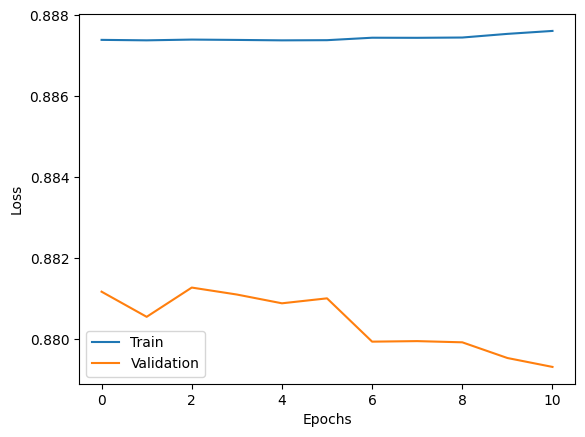

0.9448413832523578

In [153]:
epochs = 100

W_train_poly, errors, val_errors = fit(X_train_poly, y_train, W_poly, X_val_poly, y_val, lr=0.0001, epochs=epochs, print_every=epochs/10, batch_size=256)

plot_errors(errors, val_errors)

y_pred = predict(X_val_poly, W_train_poly)
y_pred_round = y_pred.round()
mse(y_val, y_pred_round)

In [155]:
# export weights
np.save('weights8.npy', W_train_poly)
W_backup = W_train_poly

In [156]:
X_val_poly = transform_input(X_val)
y_pred = predict(X_val_poly, W_poly)
y_pred_round = y_pred.round()

mse(y_val, y_pred_round)

0.9448413832523578

In [159]:
# Get output for final test data
X_final_test = np.array(test.drop('ID', axis=1))
X_final_test_poly = transform_input(X_final_test)
y_final_test = predict(X_final_test_poly, W_poly)
y_final_test = y_final_test.round()

output = pd.DataFrame({'ID': test['ID'], 'score': y_final_test.flatten()})

output['score'] = output['score'].clip(0, 5)

# count score < 0
below0 = output[output['score'] < 0].shape[0]

# count score > 5
above5 = output[output['score'] > 5].shape[0]

print(output.shape[0], below0, above5)

output.to_csv('output8.csv', index=False)

14996 0 0


In [160]:
# compare output7 and output8
output7 = pd.read_csv('output7.csv')
output8 = pd.read_csv('output8.csv')

(output7['score'] == output8['score']).sum()

14996

In [68]:
import tensorflow as tf

def gaussian_basis(x):
    # Mean and variance
    mu = np.mean(x)
    sigma = np.std(x)
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

# Add polynomial features
def transform_input(X, basis):
    transormed_X = np.hstack([basis[i](X) for i in range(len(basis))])
    transormed_X = np.hstack([X, transormed_X])
    return transormed_X

basis_funcs = [
    [normalize],
    [gaussian_basis],
    [sigmoid],
    [sigmoid, gaussian_basis, normalize],
]

for basis in basis_funcs:
    transformed_X_train = transform_input(X_train, basis)
    transformed_X_val = transform_input(X_val, basis)
    
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(transformed_X_train.shape[1],)),
        tf.keras.layers.Dense(1)
    ])
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(transformed_X_train, y_train, validation_data=(transformed_X_val, y_val), epochs=10, verbose=0)
    train_loss, val_loss = model.evaluate(transformed_X_train, y_train), model.evaluate(transformed_X_val, y_val)
    print(basis, train_loss, val_loss)

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - loss: 0.8705
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - loss: 0.8961
[<function normalize at 0x38ef3daf0>] 0.8870629668235779 0.8694994449615479
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.8607
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - loss: 0.8802
[<function gaussian_basis at 0x3b3d63550>] 0.8777105212211609 0.8520484566688538
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.8657
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - loss: 0.8883
[<function sigmoid at 0x38375dee0>] 0.882866621017456 0.8620593547821045
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.8679
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - loss: 0.8938
[<function sigmoid at 0x38375dee0>, <function gaussian_basis at 0x3b3d63550>, <function normalize at 0x38ef3daf0>] 0.8849837779998779 0.8647343516349792


In [40]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.fit(transformed_X_train, y_train, validation_data=(transformed_X_val, y_val), epochs=10)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 1.3638 - val_loss: 1.0372
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - loss: 0.9448 - val_loss: 0.9532
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - loss: 0.9095 - val_loss: 0.9712
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - loss: 0.8788 - val_loss: 0.9324
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - loss: 0.8806 - val_loss: 0.8915
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - loss: 0.8550 - val_loss: 0.9437
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - loss: 0.8317 - val_loss: 0.8486
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - loss: 0.8230 - val_loss: 0.8512
Epoch 9/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 0.8435 - val_loss: 0.8431
Epoch 10/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 0.8142 - val_loss: 0.8732


In [214]:
import tensorflow as tf

# Add polynomial features
def transform_input(X, basis):
    transormed_X = np.hstack([basis[i](X) for i in range(len(basis))])
    transormed_X = np.hstack([X, transormed_X])
    return transormed_X

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gaussian_basis(x):
    # Mean and variance
    mu = np.mean(x)
    sigma = np.std(x)
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

basis = [gaussian_basis]

transformed_X_train = transform_input(X_train, basis)
transformed_X_val = transform_input(X_val, basis)

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(transformed_X_train.shape[1],)),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_134 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

In [215]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')
model.fit(transformed_X_train, y_train, validation_data=(transformed_X_val, y_val), epochs=100)

Epoch 1/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 3.3207 - val_loss: 1.4445
Epoch 2/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 1.3784 - val_loss: 1.3350
Epoch 3/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.2782 - val_loss: 1.2485
Epoch 4/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.2242 - val_loss: 1.1806
Epoch 5/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 1.1312 - val_loss: 1.1279
Epoch 6/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 1.0916 - val_loss: 1.0818
Epoch 7/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 1.0511 - val_loss: 1.0465
Epoch 8/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 1.0085 - val_loss: 1.0163
Epoch 9/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 0.9937 - val_loss: 0.9920
Epoch 10/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 0.9806 - val_loss: 0.9714
Epoch 11/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - loss: 0.9652 - val_loss: 0.9547
Epoch 12/100
985/98

In [216]:
# RMSE
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_val, model.predict(transformed_X_val))
rmse.result().numpy()

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


0.93085057

0.92 current best rmse on val set submitted
0.87 ideally should be the best rmse on val set